### Purpose

Previously we've been using specific timepoints to get the directional vector for a particular gaze of a product. 

The better solution here is to detect the multiple ranges of times at which there are different generating distributions of the data observed (in our case, pitch/yaw/roll angles).

### Import data

In [5]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

DATA_DIR = 'notebook_data'
VIDEOS_DIR = 'videos'

ORIGINAL_VIDEO_FILENAME = 'Camera 1 - Vendlytics Prototype.mp4'
FACE_DETECTION_VIDEO_FILENAME = 'output-_local.avi'
GAZE_DETECTION_VIDEO_FILENAME = 'output-_local_1.avi'

FACE_BBOXES_FILENAME = 'frame_to_bbox.txt'
GAZE_ANGLES_FILENAME = 'frame_to_gaze.txt'

ORIGINAL_VIDEO_PATH = os.path.join(DATA_DIR, VIDEOS_DIR, ORIGINAL_VIDEO_FILENAME)
FACE_DETECTION_VIDEO_PATH = os.path.join(DATA_DIR, VIDEOS_DIR, FACE_DETECTION_VIDEO_FILENAME)
GAZE_DETECTION_VIDEO_PATH = os.path.join(DATA_DIR, VIDEOS_DIR, GAZE_DETECTION_VIDEO_FILENAME)
FACE_BBOXES_PATH = os.path.join(DATA_DIR, FACE_BBOXES_FILENAME)
GAZE_ANGLES_PATH = os.path.join(DATA_DIR, GAZE_ANGLES_FILENAME)

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


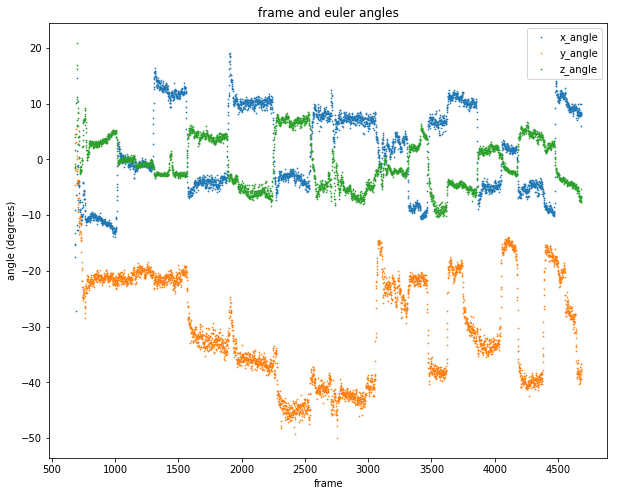

In [6]:
bbox_df = pd.read_csv(FACE_BBOXES_PATH, delimiter=' ', header=None)
bbox_df.columns = ['frame_number', 'x_min', 'y_min', 'x_max', 'y_max', 'confidence_score']

gaze_df = pd.read_csv(GAZE_ANGLES_PATH, delimiter=' ', header=None)
gaze_df.columns = ['frame_number', 'x_angle', 'y_angle', 'z_angle']

MARKER_SIZE = 0.5
FRAME_LIMIT = 4000

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)

x = gaze_df.T.loc['frame_number'][:FRAME_LIMIT]
ax1.scatter(x, gaze_df.T.loc['x_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # x angle
ax1.scatter(x, gaze_df.T.loc['y_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # y angle
ax1.scatter(x, gaze_df.T.loc['z_angle'][:FRAME_LIMIT], s=MARKER_SIZE) # z angle

plt.title("frame and euler angles")
plt.xlabel("frame")
plt.ylabel("angle (degrees)")

plt.legend(["x_angle", "y_angle", "z_angle"])
fig.show()

In [7]:
# times (s) when ashton was looking at each of 7 products
TIME_MARKERS_SEC = [27, 34, 44, 53, 66, 77, 87]

# we know video is 30 fps, so 30 * TIME_MARKERS_SEC[i] 
# (where i is single product) gives us frame to use angle from
TIME_MARKERS_FRAMES = [(30 * i) for i in TIME_MARKERS_SEC]

print(TIME_MARKERS_FRAMES)

[810, 1020, 1320, 1590, 1980, 2310, 2610]


### VAE setup

Gaze direction vector during one product viewing is probably a Gaussian.

In [21]:
import os

import numpy as np
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [22]:
class EulerAnglesDataset(torch.utils.data.Dataset):
    """Euler Angles dataset."""
    
    def __init__(self, csv_file, transform=None):
        self.euler_angles_frame = pd.read_csv(GAZE_ANGLES_PATH, delimiter=' ', header=None)
        self.euler_angles_frame.columns = ['frame_number', 'x_angle', 'y_angle', 'z_angle']
    
    def __len__(self):
        return len(self.euler_angles_frame)
    
    def __getitem__(self, idx):
        frame = self.euler_angles_frame.iloc[idx, 0]
        euler_angles = self.euler_angles_frame.iloc[idx, 1:].as_matrix()
        sample = {'frame': frame, 'euler_angles': euler_angles}
        return sample

In [16]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

In [17]:
gaze_dataset = EulerAnglesDataset(csv_file=GAZE_ANGLES_PATH)

In [18]:
len(gaze_dataset)

12113

In [20]:
def setup_data_loaders(batch_size=128, use_cuda=True):
    trans = transforms.ToTensor()
    train_set = EulerAnglesDataset(csv_file)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img